### Load Libraries

In [1]:
import gpxpy
import shapely.geometry as geometry
from shapely.geometry import LineString
import pyproj 
import osmnx as ox
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
from IPython.display import display


### Load Data

In [2]:
# parse the GPX file
with open('at_centerline_full.gpx', 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

track_points = [(point.latitude, point.longitude) for point in gpx.tracks[0].segments[0].points]

# check if the GPX file's coordinates are in degrees
if -180 <= track_points[0][0] <= 180 and -180 <= track_points[0][1] <= 180:
    print("The coordinates were in degrees")
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    track_points = [transformer.transform(point[1], point[0]) for point in track_points]
else :
    print("The coordinates are in metres")

track_linestring = LineString(track_points)

# Create the buffer
buffer_distance = 3219 # this is a radius of 2 miles in meters
buffer_polygon = track_linestring.buffer(buffer_distance)

# Define the original and desired projections
inProj = pyproj.Proj(init='epsg:3857') # Web Mercator
outProj = pyproj.Proj(init='epsg:4326') # WGS 84

# Convert the coordinates of the Polygon object
buffer_polygon_4326 = shapely.ops.transform(lambda x, y: pyproj.transform(inProj, outProj, x, y), buffer_polygon)

# extract all the toilets within the buffer zone
toilets = ox.geometries.geometries_from_polygon(buffer_polygon_4326, tags={'amenity': 'toilets'})
toilets_df = pd.DataFrame(toilets)
toilets_df = toilets_df[['fee', 'toilets:disposal', 'access', 'shower', 'composting', 'opening_hours']]

The coordinates were in degrees


c:\Users\Ashley\anaconda3\envs\atrail\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Ashley\anaconda3\envs\atrail\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Ashley\AppData\Local\Temp\ipykernel_19000\4221427731.py:26: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-f

In [3]:
toilets_df = toilets_df[['fee', 'toilets:disposal', 'access', 'shower', 'composting', 'opening_hours']]

### Questions

#### Summary

In [4]:
for column in toilets_df:
    display(pd.DataFrame(toilets_df[column].value_counts(dropna=False)).style)

,count
fee,
nan,235
no,44
yes,1


,count
toilets:disposal,
nan,156
pitlatrine,82
flush,32
chemical,7
composting,3


,count
access,
nan,223
yes,39
customers,10
private,4
permissive,3
permit,1


,count
shower,
nan,275
hot,5


,count
composting,
nan,277
yes,3


,count
opening_hours,
nan,271
Mar 30-Nov12 open,6
24/7,2
Mar 17-Dec 21 open,1


In [22]:
toilets_df[(toilets_df['composting'] == 'yes') | (toilets_df['toilets:disposal'] == 'composting')]

fee toilets:disposal access changing_table building   
element_type osmid                                                              
node         10056550700  NaN       composting    NaN            NaN      NaN  \
             10280669898  NaN       composting    NaN            NaN      NaN   
             10084857979  NaN       composting    NaN            NaN      NaN   
             3633676728   NaN       pitlatrine    NaN            NaN      NaN   
             2317822827   NaN       pitlatrine    yes            NaN      NaN   
             8307445302   NaN       pitlatrine    NaN            NaN      NaN   

                         shower composting opening_hours  
element_type osmid                                        
node         10056550700    NaN        NaN           NaN  
             10280669898    NaN        NaN           NaN  
             10084857979    NaN        NaN           NaN  
             3633676728     NaN        yes           NaN  
             2317822827     NaN        yes           NaN  
             8307445302     NaN        yes           NaN

In [31]:
toilets_df[toilets_df['toilets:disposal'].isna()]

fee toilets:disposal access shower composting   
element_type osmid                                                       
node         1112529291  NaN              NaN    NaN    NaN        NaN  \
             2324985152  NaN              NaN    NaN    NaN        NaN   
             3980579566  NaN              NaN    NaN    NaN        NaN   
             3980579567  NaN              NaN    NaN    NaN        NaN   
             4203341950  NaN              NaN    NaN    NaN        NaN   
...                      ...              ...    ...    ...        ...   
             9842947929  NaN              NaN    NaN    NaN        NaN   
way          438418225   NaN              NaN    NaN    NaN        NaN   
             438418229   NaN              NaN    NaN    NaN        NaN   
node         9891929797  NaN              NaN    NaN    NaN        NaN   
             7149645254  NaN              NaN    NaN    NaN        NaN   

                        opening_hours  
element_type osmid                     
node         1112529291           NaN  
             2324985152           NaN  
             3980579566           NaN  
             3980579567           NaN  
             4203341950           NaN  
...                               ...  
             9842947929           NaN  
way          438418225            NaN  
             438418229            NaN  
node         9891929797           NaN  
             7149645254           NaN  

[156 rows x 6 columns]

#### Insights

In [5]:
# print the number of toilets found
print(f"Number of toilets found within the buffer zone: {len(toilets)}")

# one toilet says it has a fee
for _, row in toilets.iterrows():
    if row['fee'] == 'yes':
        location = row.geometry.centroid.coords[0][::-1]
        print(f"The location of the toilet with fee 'yes' is: {location}")

# four say they're private
for _, row in toilets.iterrows():
    if row['access'] == 'private':
        location = row.geometry.centroid.coords[0][::-1]
        print(f"The location of the toilet with access 'private' is: {location}")

Number of toilets found within the buffer zone: 280
The location of the toilet with fee 'yes' is: (36.8862462, -81.3727961)
The location of the toilet with access 'private' is: (34.6609716, -84.0447205)
The location of the toilet with access 'private' is: (34.6609931, -84.0446984)
The location of the toilet with access 'private' is: (35.95936905221848, -82.51081226639641)
The location of the toilet with access 'private' is: (39.812797, -77.4811512)


#### Graphs

In [10]:
import matplotlib.pyplot as plt

toilets:disposal
NaN           156
pitlatrine     82
flush          32
chemical        7
composting      3
Name: count, dtype: int64

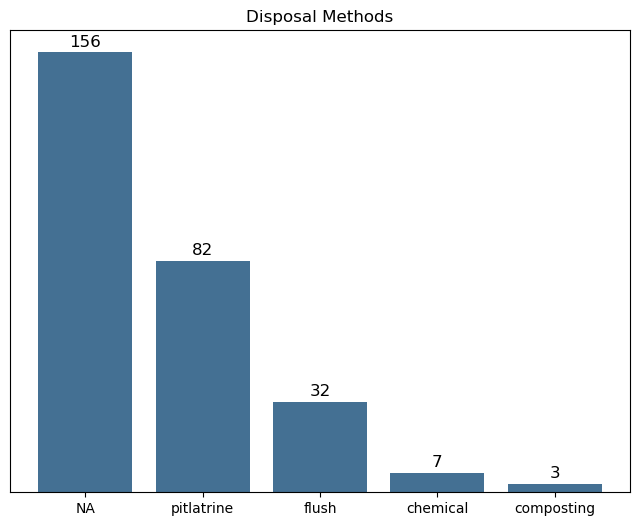

In [32]:
# Get the value counts for the "toilets:disposal" column
disposal_counts = toilets_df['toilets:disposal'].fillna('NA').value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(disposal_counts.index, disposal_counts.values, color='#447093')

# Set the chart title and axis labels
ax.set_title('Disposal Methods')

# Remove the y-axis labels
ax.set_yticks([])
ax.set_yticklabels([])

# Add the count numbers to the top of each bar
for i, v in enumerate(disposal_counts.values):
    ax.text(i, v+2, str(v), ha='center', fontsize=12)

# Save the chart as a PNG file
plt.savefig('disposal_methods.png', dpi=300, bbox_inches='tight')